In [1]:
import pandas as pd
import pyodbc
import numpy as np

class get_df:

    def __init__(self):
        self.DB_infos = {"X01" : ("192.168.1.16", "X01", "cm23357868", "86875332")}
        self.querys = {}
        self.db = str()
        self.df_dict =  dict()
        self.w_code_dict = dict()
        self.point_dict = dict()
        self.result_dict = dict()
        
    def db_connect(self, DB_info):
        DB_Host, DB_Name, DB_User, DB_Password = self.DB_infos[DB_info]
        print("Connecting to database using pyodbc...")
        self.db = pyodbc.connect('DRIVER={ODBC Driver 13 for SQL Server}; SERVER=' + DB_Host + '; DATABASE=' + DB_Name + '; UID=' + DB_User + '; PWD=' + DB_Password)
        print("Succesfully Connected to database using pyodbc!")
      
    def load_data(self, query):
        df =  pd.read_sql(self.querys[query], self.db)
        return df
    @staticmethod
    def make_BSE():
        df ="""SELECT    [日期]
                        ,[代號]
                        ,[名稱]
                        ,[開盤價]
                        ,[最高價]
                        ,[最低價]
                        ,[收盤價]
                        ,[漲跌]
                        ,[漲跌幅(%)]
                        ,[振幅(%)]
                        ,[成交量(股)]
                        ,[成交金額(元)]
                        ,[成交筆數]
                        ,[流通股本(股)]
                        ,[流通市值(元)]
                        ,[流通市值比重(%)]
                        ,[市盈率]
                        ,[市淨率]
                        ,[資料修改時間]
                        ,[RTIME]
                      
     
                    FROM [X01].[dbo].[陸股日收盤表排行] where 日期 >= 20220101 order by 日期"""

        return df

In [2]:
sql_base = get_df()
sql_base.db_connect('X01')
sql_base.querys['BSE'] = sql_base.make_BSE()

Connecting to database using pyodbc...
Succesfully Connected to database using pyodbc!


In [3]:
BSE行情表 = sql_base.load_data('BSE')
BSE行情表 = BSE行情表.sort_values(by = ['日期','代號']).reset_index(drop = True)

In [4]:
BSE行情表['日期'] = pd.to_datetime(BSE行情表['日期'],format = "%Y%m%d").fillna(0)
BSE行情表 = BSE行情表.set_index('日期')

In [5]:
BSE1 = pd.Series(BSE行情表['代號'])

In [6]:
BSElist = BSE1.sort_values().drop_duplicates()

In [7]:
BSElist = list(BSElist)

In [8]:
from tqdm import tqdm
BSE_dict = {str(BSElist[i]):BSE行情表[BSE行情表['代號'] == BSElist[i]] for i in tqdm(range(len(BSElist)))}


100%|██████████| 10567/10567 [38:10<00:00,  4.61it/s]


In [9]:
feature_ls = BSE行情表.columns[2:]
BSE行情表 =BSE行情表.reset_index(drop = False)
data_pivots_ls = []
for feature in tqdm(BSE行情表.columns[2:]):
    data_pivot = BSE行情表.pivot('日期','代號',feature)
    data_pivots_ls.append(data_pivot)

100%|██████████| 18/18 [00:22<00:00,  1.26s/it]


In [10]:
pivot_dict = {str(BSE行情表.columns[2:][i]):data_pivots_ls[i] for i in range(len(BSE行情表.columns[2:]))}

BSE_dict.update(pivot_dict)

In [11]:
BSEDDW = {}
for j in tqdm(BSElist):
    BSEDDW[str(j)] = BSE_dict[str(j)].resample('W-FRI').agg({'開盤價':'first', '最高價':'max', '最低價':'min', '收盤價':'last', '成交金額(元)':'sum'\
                                                           }).fillna(method = 'pad' ,axis = 0)

100%|██████████| 10567/10567 [00:54<00:00, 194.10it/s]


100%|██████████| 10567/10567 [1:27:10<00:00,  2.02it/s]


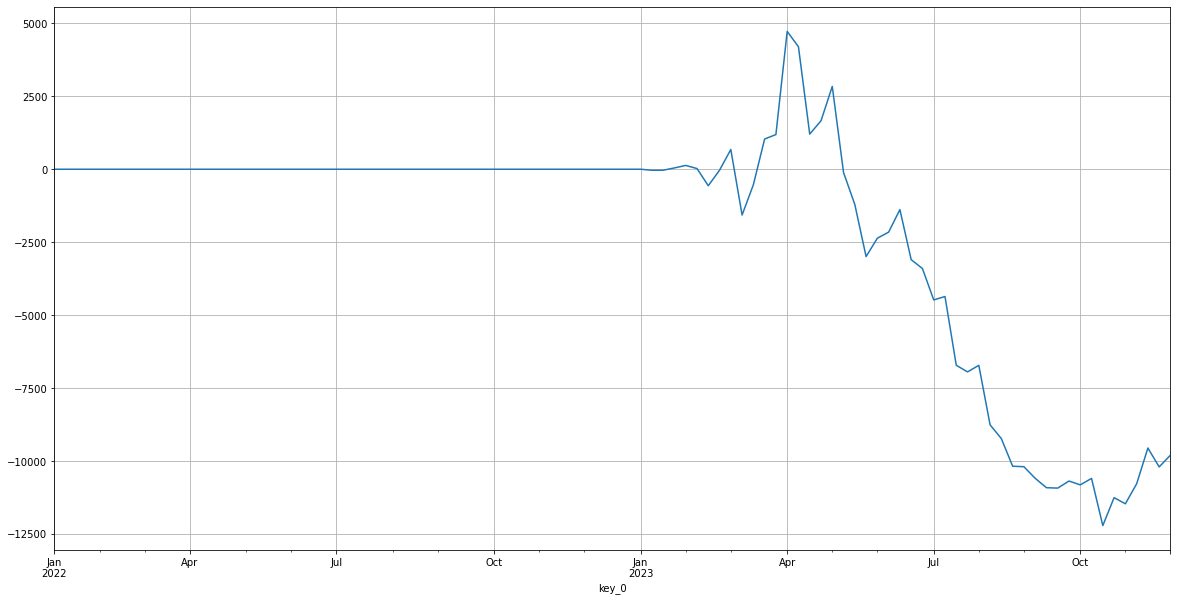

In [18]:
import talib
ERROR = []
trr = pd.DataFrame()
pz = pd.DataFrame()

for x in tqdm(BSElist):
    
    BSEDDW[str(x)]['MAX52'] = BSEDDW[str(x)]["收盤價"].rolling(52).max()
    BSEDDW[str(x)]["MAX52S"] = BSEDDW[str(x)]["MAX52"].shift(1)
    BSEDDW[str(x)]["4MA"] = talib.MA(BSEDDW[str(x)]["收盤價"].fillna(0), timeperiod=4, matype=0)
    BSEDDW[str(x)]["4MAS"] = BSEDDW[str(x)]["4MA"].shift(1)
    BSEDDW[str(x)]["DR"] = ((BSEDDW[str(x)]["收盤價"] - BSEDDW[str(x)]["收盤價"].shift(1))/BSEDDW[str(x)]["收盤價"].shift(1))*100
    
    
    KPBS = 0
    KPBUY =[]
    for z in range(len(BSEDDW[str(x)])):

        if BSEDDW[str(x)]["收盤價"].iloc[z]  > BSEDDW[str(x)]["MAX52S"].iloc[z] and BSEDDW[str(x)]['成交金額(元)'].iloc[z] > 30000 and BSEDDW[str(x)]['4MA'].iloc[z] > BSEDDW[str(x)]["4MAS"].iloc[z] :
        
            KPBS = 1

        elif  BSEDDW[str(x)]['收盤價'].iloc[z] < BSEDDW[str(x)]['最低價'].rolling(3).min().shift(1).iloc[z] \
         :
            KPBS = 0
            #buy.append("0")
        KPBUY.append(KPBS)
    BSEDDW[str(x)]["KPBUY"] = KPBUY
    BSEDDW[str(x)]["KPBUYS"] = BSEDDW[str(x)]["KPBUY"].shift(1)
    pzb = BSEDDW[str(x)]["KPBUYS"]  
    pzb.name = str(x)
    pzbs = BSEDDW[str(x)]["KPBUY"]
    pzbs.name = str(x)
    BSEDDW[str(x)]["KPRR"] = BSEDDW[str(x)]["DR"] * BSEDDW[str(x)]["KPBUYS"].dropna().astype(int)
    PT = BSEDDW[str(x)]["KPRR"]
    PT.name = str(x)
    if len(trr) == 0:
        trr = PT
    else:
        trr = pd.merge(trr,PT,left_on = trr.index,right_on = PT.index,how = 'outer')
        trr.set_index('key_0',inplace = True)
    if len(pz) == 0:
        pz = pzbs
    else:
        pz = pd.merge(pz,pzbs,left_on = pz.index,right_on = pzbs.index,how = 'outer')
        pz.set_index('key_0',inplace = True)

trrb =(trr*1).replace(np.inf,0).sort_index().sum(axis = 1).cumsum().plot(figsize=(20, 10),grid = True)